## RetinaNet Training

In [ ]:
import torch
import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection import RetinaNet_ResNet50_FPN_Weights
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import CocoDetection
import torchvision.transforms as T
import json
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from collections import defaultdict
import os

#RETINANET for sign conditions

train_json = r'COCO-based_COCO_condition\annotations\train.json'
val_json = r'COCO-based_COCO_condition\annotations\val.json'
train_img_dir = r'COCO-based_COCO_condition\images\train'
val_img_dir = r'COCO-based_COCO_condition\images\val'

# conditions
allowed_conditions = ["Good", "Weathered", "Heavily Damaged"]

#3 conditions + 1 background = 4
num_classes = 4

# parameters
BATCH_SIZE = 4
NUM_EPOCHS = 15
LEARNING_RATE = 0.0001
NUM_WORKERS = 0  

#early stopping
PATIENCE = 5

#tensorBoard configuration
EXPERIMENT_NAME = f"retinanet_balanced_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
LOG_DIR = os.path.join('runs', EXPERIMENT_NAME)


class FilteredCocoDetection(CocoDetection):
    def __init__(self, root, annFile, allowed_conditions):
        super().__init__(root, annFile)
        self.annFile = annFile
        self.allowed_conditions = allowed_conditions
        self._filter_annotations()
    
    def _filter_annotations(self):
        """Filter annotations to only include allowed conditions"""
        with open(self.annFile, 'r') as f:
            data = json.load(f)
        
        filtered_anns = []
        for ann in data['annotations']:
            if 'attributes' in ann and 'condition' in ann['attributes']:
                condition = ann['attributes']['condition'][0]
                if condition in self.allowed_conditions:
                    ann['category_id'] = self.allowed_conditions.index(condition) + 1
                    filtered_anns.append(ann)
        
        print(f"Filtered {len(data['annotations'])} -> {len(filtered_anns)} annotations")
        
        data['annotations'] = filtered_anns
        data['categories'] = [
            {'id': i+1, 'name': cond} 
            for i, cond in enumerate(self.allowed_conditions)
        ]
        
        self.coco.dataset = data
        self.coco.createIndex()
    
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        
        #convert image to tensor
        img = T.ToTensor()(img)
        
        #convert target to proper format
        boxes = []
        labels = []
        
        for obj in target:
            if 'bbox' in obj and 'category_id' in obj:
                x, y, w, h = obj['bbox']
                boxes.append([x, y, x + w, y + h])
                labels.append(obj['category_id'])
        
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target_dict = {
            'boxes': boxes,
            'labels': labels
        }
        
        return img, target_dict


model = retinanet_resnet50_fpn(weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT)

#classification head for number of classes
in_features = 256
num_anchors = model.head.classification_head.num_anchors

from torchvision.models.detection.retinanet import RetinaNetClassificationHead
model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_features,
    num_anchors=num_anchors,
    num_classes=num_classes
)


print("Training set:")
train_dataset = FilteredCocoDetection(
    root=train_img_dir, 
    annFile=train_json, 
    allowed_conditions=allowed_conditions
)

print("\nValidation set:")
val_dataset = FilteredCocoDetection(
    root=val_img_dir, 
    annFile=val_json, 
    allowed_conditions=allowed_conditions
)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)} images")
print(f"  Val: {len(val_dataset)} images")


#count instances per class and track each sample's classes
class_instance_count = defaultdict(int)
sample_labels = []

for idx in range(len(train_dataset)):
    _, target = train_dataset[idx]
    labels = target['labels'].tolist()
    
    if labels:
        sample_labels.append(labels)
        for label in labels:
            class_instance_count[label] += 1
    else:
        sample_labels.append([1])  # Default to class 1 if no labels

print("\nOriginal class distribution (instances):")
for cls in sorted(class_instance_count.keys()):
    count = class_instance_count[cls]
    pct = 100 * count / sum(class_instance_count.values())
    print(f"  {allowed_conditions[cls-1]}: {count} ({pct:.1f}%)")

# Calculate class weights (inverse frequency)
total_instances = sum(class_instance_count.values())
class_weights = {}
for cls, count in class_instance_count.items():
    # Weight is inversely proportional to frequency
    # Add smoothing to avoid extreme weights
    class_weights[cls] = total_instances / (count * len(class_instance_count))

print("\nClass weights (for sampling):")
for cls in sorted(class_weights.keys()):
    print(f"  {allowed_conditions[cls-1]}: {class_weights[cls]:.2f}")

#assign weight to each sample based on rarest class present
sample_weights = []
for labels in sample_labels:
    # Weight by the rarest class in the image
    weights = [class_weights[label] for label in labels]
    sample_weights.append(max(weights))

#weighted random sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print(f"\nWeighted sampler created with {len(sample_weights)} samples")

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=sampler,  
    num_workers=NUM_WORKERS, 
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    collate_fn=collate_fn
)

print(f"\nSteps per epoch:")
print(f"  Train: {len(train_loader)} steps")
print(f"  Val: {len(val_loader)} steps")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=LEARNING_RATE, weight_decay=0.0001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)


writer = SummaryWriter(log_dir=LOG_DIR)

writer.add_text('Hyperparameters', f'''
- Batch Size: {BATCH_SIZE}
- Learning Rate: {LEARNING_RATE}
- Weight Decay: 0.0005
- Optimizer: AdamW
- Scheduler: ReduceLROnPlateau (patience=5, factor=0.5)
- Number of Classes: {num_classes}
- Conditions: {", ".join(allowed_conditions)}
- Train Images: {len(train_dataset)}
- Val Images: {len(val_dataset)}
- **BALANCED SAMPLING ENABLED**
- Class Weights: Good={class_weights[1]:.2f}, Weathered={class_weights[2]:.2f}, Heavily Damaged={class_weights[3]:.2f}
''')


#tensorboard --logdir=runs


print(f"\nStarting training for {NUM_EPOCHS} epochs")


best_val_loss = float('inf')
patience_counter = 0
global_step = 0

for epoch in range(NUM_EPOCHS):

    model.train()
    train_loss = 0
    train_cls_loss = 0
    train_box_loss = 0
    
    # Track which classes appear in batches
    epoch_class_counts = defaultdict(int)
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for batch_idx, (images, targets) in enumerate(pbar):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # track class distribution in this batch
        for target in targets:
            for label in target['labels']:
                epoch_class_counts[label.item()] += 1
        
        # skip empty batches
        if any(len(t['boxes']) == 0 for t in targets):
            continue
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        cls_loss = loss_dict.get('classification', torch.tensor(0.0))
        box_loss = loss_dict.get('bbox_regression', torch.tensor(0.0))
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += losses.item()
        train_cls_loss += cls_loss.item()
        train_box_loss += box_loss.item()
        
        # log to TensorBoard
        writer.add_scalar('Train/Batch_Loss', losses.item(), global_step)
        writer.add_scalar('Train/Batch_Classification_Loss', cls_loss.item(), global_step)
        writer.add_scalar('Train/Batch_BBox_Loss', box_loss.item(), global_step)
        
        global_step += 1
        pbar.set_postfix({'loss': f'{losses.item():.4f}'})
    
    train_loss = train_loss / len(train_loader)
    train_cls_loss = train_cls_loss / len(train_loader)
    train_box_loss = train_box_loss / len(train_loader)
    
    # log class distribution seen during training
    print(f"\nClasses seen in epoch {epoch+1}:")
    total_seen = sum(epoch_class_counts.values())
    for cls in sorted(epoch_class_counts.keys()):
        count = epoch_class_counts[cls]
        pct = 100 * count / total_seen if total_seen > 0 else 0
        print(f"  {allowed_conditions[cls-1]}: {count} ({pct:.1f}%)")
        writer.add_scalar(f'Training_Distribution/{allowed_conditions[cls-1]}', count, epoch)
    
   
    model.train()
    val_loss = 0
    val_cls_loss = 0
    val_box_loss = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Val]  ')
        for images, targets in pbar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            if any(len(t['boxes']) == 0 for t in targets):
                continue
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            cls_loss = loss_dict.get('classification', torch.tensor(0.0))
            box_loss = loss_dict.get('bbox_regression', torch.tensor(0.0))
            
            val_loss += losses.item()
            val_cls_loss += cls_loss.item()
            val_box_loss += box_loss.item()
            
            pbar.set_postfix({'loss': f'{losses.item():.4f}'})
    
    val_loss = val_loss / len(val_loader)
    val_cls_loss = val_cls_loss / len(val_loader)
    val_box_loss = val_box_loss / len(val_loader)
    
    # update scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    writer.add_scalars('Loss/Total', {'train': train_loss, 'val': val_loss}, epoch)
    writer.add_scalars('Loss/Classification', {'train': train_cls_loss, 'val': val_cls_loss}, epoch)
    writer.add_scalars('Loss/BBox_Regression', {'train': train_box_loss, 'val': val_box_loss}, epoch)
    
    overfit_ratio = train_loss / val_loss if val_loss > 0 else 1.0
    writer.add_scalar('Metrics/Overfit_Ratio', overfit_ratio, epoch)
    writer.add_scalar('Hyperparameters/Learning_Rate', current_lr, epoch)
    
   
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}:')
    print(f'  Train Loss: {train_loss:.4f} (cls: {train_cls_loss:.4f}, bbox: {train_box_loss:.4f})')
    print(f'  Val Loss:   {val_loss:.4f} (cls: {val_cls_loss:.4f}, bbox: {val_box_loss:.4f})')
    print(f'  Overfit Ratio: {overfit_ratio:.3f}')
    print(f'  LR: {current_lr:.6f}')
    
    
    if val_loss < best_val_loss:
        improvement = best_val_loss - val_loss
        best_val_loss = val_loss
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'class_weights': class_weights,
        }, 'retinanet_best.pth')
        
        print(f'New best model saved (improved by {improvement:.4f})')
        writer.add_scalar('Metrics/Best_Val_Loss', best_val_loss, epoch)
    else:
        patience_counter += 1
        print(f'  Patience: {patience_counter}/{PATIENCE}')
        
        if patience_counter >= PATIENCE:
            print(f'\nEarly stopping triggered at epoch {epoch+1}')
            break
    
    # Save last model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'class_weights': class_weights,
    }, 'retinanet_last.pth')
    

print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Stopped at epoch: {epoch+1}")

writer.close()

Training set:
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Filtered 571 -> 571 annotations
creating index...
index created!

Validation set:
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Filtered 110 -> 110 annotations
creating index...
index created!

Dataset sizes:
  Train: 488 images
  Val: 93 images

Original class distribution (instances):
  Good: 369 (64.6%)
  Weathered: 172 (30.1%)
  Heavily Damaged: 30 (5.3%)

Class weights (for sampling):
  Good: 0.52
  Weathered: 1.11
  Heavily Damaged: 6.34

Weighted sampler created with 488 samples

Steps per epoch:
  Train: 122 steps
  Val: 24 steps

Using device: cuda

Starting training for 15 epochs


Epoch 1/15 [Train]: 100%|██████████| 122/122 [04:30<00:00,  2.21s/it, loss=0.7219]



Classes seen in epoch 1:
  Good: 184 (32.6%)
  Weathered: 182 (32.2%)
  Heavily Damaged: 199 (35.2%)


Epoch 1/15 [Val]  : 100%|██████████| 24/24 [00:39<00:00,  1.65s/it, loss=0.7639]



Epoch 1/15:
  Train Loss: 0.8389 (cls: 0.6261, bbox: 0.2128)
  Val Loss:   0.7700 (cls: 0.5293, bbox: 0.2407)
  Overfit Ratio: 1.090
  LR: 0.000100
New best model saved (improved by inf)


Epoch 2/15 [Train]: 100%|██████████| 122/122 [04:35<00:00,  2.26s/it, loss=0.4243]



Classes seen in epoch 2:
  Good: 161 (28.6%)
  Weathered: 211 (37.5%)
  Heavily Damaged: 190 (33.8%)


Epoch 2/15 [Val]  : 100%|██████████| 24/24 [00:42<00:00,  1.75s/it, loss=0.7731]



Epoch 2/15:
  Train Loss: 0.5629 (cls: 0.3945, bbox: 0.1684)
  Val Loss:   0.7049 (cls: 0.4638, bbox: 0.2412)
  Overfit Ratio: 0.798
  LR: 0.000100
New best model saved (improved by 0.0651)


Epoch 3/15 [Train]: 100%|██████████| 122/122 [04:45<00:00,  2.34s/it, loss=0.3567]



Classes seen in epoch 3:
  Good: 210 (36.9%)
  Weathered: 206 (36.2%)
  Heavily Damaged: 153 (26.9%)


Epoch 3/15 [Val]  : 100%|██████████| 24/24 [00:40<00:00,  1.70s/it, loss=0.6725]



Epoch 3/15:
  Train Loss: 0.5188 (cls: 0.3572, bbox: 0.1616)
  Val Loss:   0.6536 (cls: 0.4122, bbox: 0.2414)
  Overfit Ratio: 0.794
  LR: 0.000100
New best model saved (improved by 0.0513)


Epoch 4/15 [Train]: 100%|██████████| 122/122 [04:42<00:00,  2.32s/it, loss=0.6278]



Classes seen in epoch 4:
  Good: 203 (35.2%)
  Weathered: 204 (35.4%)
  Heavily Damaged: 170 (29.5%)


Epoch 4/15 [Val]  : 100%|██████████| 24/24 [00:36<00:00,  1.52s/it, loss=0.6997]



Epoch 4/15:
  Train Loss: 0.4758 (cls: 0.3352, bbox: 0.1406)
  Val Loss:   0.6430 (cls: 0.4060, bbox: 0.2370)
  Overfit Ratio: 0.740
  LR: 0.000100
New best model saved (improved by 0.0106)


Epoch 5/15 [Train]: 100%|██████████| 122/122 [04:28<00:00,  2.20s/it, loss=0.6006]



Classes seen in epoch 5:
  Good: 192 (34.7%)
  Weathered: 195 (35.2%)
  Heavily Damaged: 167 (30.1%)


Epoch 5/15 [Val]  : 100%|██████████| 24/24 [00:36<00:00,  1.50s/it, loss=0.6553]



Epoch 5/15:
  Train Loss: 0.4398 (cls: 0.3072, bbox: 0.1327)
  Val Loss:   0.6445 (cls: 0.4067, bbox: 0.2378)
  Overfit Ratio: 0.682
  LR: 0.000100
  Patience: 1/5


Epoch 6/15 [Train]: 100%|██████████| 122/122 [04:23<00:00,  2.16s/it, loss=0.7421]



Classes seen in epoch 6:
  Good: 205 (36.3%)
  Weathered: 158 (28.0%)
  Heavily Damaged: 201 (35.6%)


Epoch 6/15 [Val]  : 100%|██████████| 24/24 [00:35<00:00,  1.49s/it, loss=0.6652]



Epoch 6/15:
  Train Loss: 0.4206 (cls: 0.2909, bbox: 0.1297)
  Val Loss:   0.6045 (cls: 0.3854, bbox: 0.2191)
  Overfit Ratio: 0.696
  LR: 0.000100
New best model saved (improved by 0.0385)


Epoch 7/15 [Train]: 100%|██████████| 122/122 [04:28<00:00,  2.20s/it, loss=0.5275]



Classes seen in epoch 7:
  Good: 231 (39.2%)
  Weathered: 196 (33.3%)
  Heavily Damaged: 162 (27.5%)


Epoch 7/15 [Val]  : 100%|██████████| 24/24 [00:38<00:00,  1.61s/it, loss=0.6764]



Epoch 7/15:
  Train Loss: 0.3919 (cls: 0.2694, bbox: 0.1225)
  Val Loss:   0.5911 (cls: 0.3652, bbox: 0.2259)
  Overfit Ratio: 0.663
  LR: 0.000100
New best model saved (improved by 0.0134)


Epoch 8/15 [Train]: 100%|██████████| 122/122 [04:50<00:00,  2.38s/it, loss=0.1996]



Classes seen in epoch 8:
  Good: 197 (35.2%)
  Weathered: 201 (35.9%)
  Heavily Damaged: 162 (28.9%)


Epoch 8/15 [Val]  : 100%|██████████| 24/24 [00:40<00:00,  1.69s/it, loss=0.7633]



Epoch 8/15:
  Train Loss: 0.3525 (cls: 0.2308, bbox: 0.1217)
  Val Loss:   0.6417 (cls: 0.4057, bbox: 0.2360)
  Overfit Ratio: 0.549
  LR: 0.000100
  Patience: 1/5


Epoch 9/15 [Train]: 100%|██████████| 122/122 [04:51<00:00,  2.39s/it, loss=0.3531]



Classes seen in epoch 9:
  Good: 214 (37.1%)
  Weathered: 189 (32.8%)
  Heavily Damaged: 174 (30.2%)


Epoch 9/15 [Val]  : 100%|██████████| 24/24 [00:37<00:00,  1.58s/it, loss=0.6304]



Epoch 9/15:
  Train Loss: 0.3220 (cls: 0.2054, bbox: 0.1166)
  Val Loss:   0.6163 (cls: 0.3873, bbox: 0.2290)
  Overfit Ratio: 0.522
  LR: 0.000100
  Patience: 2/5


Epoch 10/15 [Train]: 100%|██████████| 122/122 [04:45<00:00,  2.34s/it, loss=0.2554]



Classes seen in epoch 10:
  Good: 198 (36.3%)
  Weathered: 192 (35.2%)
  Heavily Damaged: 156 (28.6%)


Epoch 10/15 [Val]  : 100%|██████████| 24/24 [00:37<00:00,  1.57s/it, loss=0.5390]



Epoch 10/15:
  Train Loss: 0.2974 (cls: 0.1890, bbox: 0.1083)
  Val Loss:   0.6365 (cls: 0.4052, bbox: 0.2313)
  Overfit Ratio: 0.467
  LR: 0.000100
  Patience: 3/5


Epoch 11/15 [Train]: 100%|██████████| 122/122 [04:46<00:00,  2.35s/it, loss=0.1381]



Classes seen in epoch 11:
  Good: 205 (36.3%)
  Weathered: 185 (32.7%)
  Heavily Damaged: 175 (31.0%)


Epoch 11/15 [Val]  : 100%|██████████| 24/24 [00:38<00:00,  1.59s/it, loss=0.4962]



Epoch 11/15:
  Train Loss: 0.2737 (cls: 0.1785, bbox: 0.0952)
  Val Loss:   0.5933 (cls: 0.3659, bbox: 0.2274)
  Overfit Ratio: 0.461
  LR: 0.000050
  Patience: 4/5


Epoch 12/15 [Train]: 100%|██████████| 122/122 [04:39<00:00,  2.29s/it, loss=0.1641]



Classes seen in epoch 12:
  Good: 203 (35.9%)
  Weathered: 195 (34.5%)
  Heavily Damaged: 167 (29.6%)


Epoch 12/15 [Val]  : 100%|██████████| 24/24 [00:39<00:00,  1.66s/it, loss=0.5655]



Epoch 12/15:
  Train Loss: 0.2135 (cls: 0.1325, bbox: 0.0810)
  Val Loss:   0.6049 (cls: 0.3931, bbox: 0.2118)
  Overfit Ratio: 0.353
  LR: 0.000050
  Patience: 5/5

Early stopping triggered at epoch 12
Best validation loss: 0.5911
Stopped at epoch: 12


Using device: cuda
Loaded model from retinanet_best.pth
  Val Loss: 0.5911
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Filtered 149 -> 149 annotations
creating index...
index created!
Test set: 122 images

Evaluating model


Evaluating: 100%|██████████| 31/31 [00:43<00:00,  1.40s/it]




EVALUATION RESULTS

Per-Class Metrics:
Good:
  Precision: 0.1905
  Recall: 0.1091
  F1-Score: 0.1387
  Avg IoU: 0.8441
  TP: 12, FP: 51, FN: 98

Weathered:
  Precision: 0.1458
  Recall: 0.4000
  F1-Score: 0.2137
  Avg IoU: 0.9179
  TP: 14, FP: 82, FN: 21

Heavily Damaged:
  Precision: 0.1111
  Recall: 0.2500
  F1-Score: 0.1538
  Avg IoU: 0.9486
  TP: 1, FP: 8, FN: 3


Overall Metrics (IoU threshold = 0.5):
  Precision: 0.1607
  Recall: 0.1812
  F1-Score: 0.1703


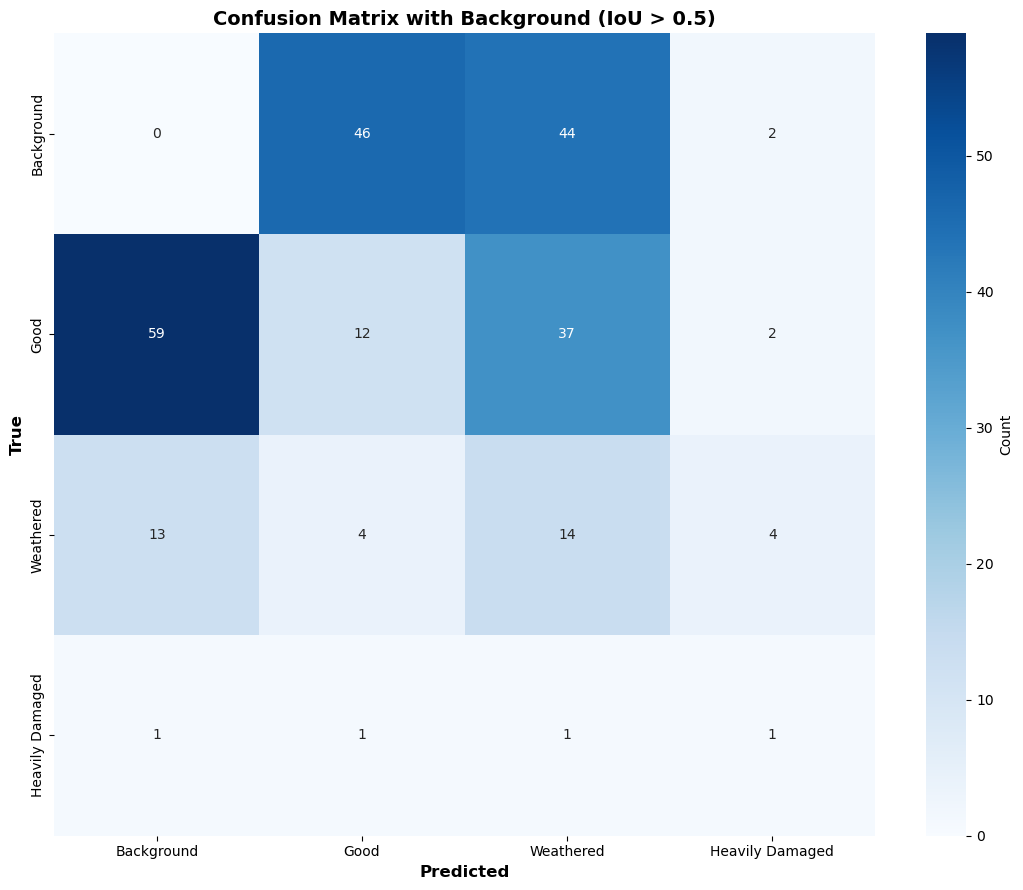


Generating Precision-Recall Curves


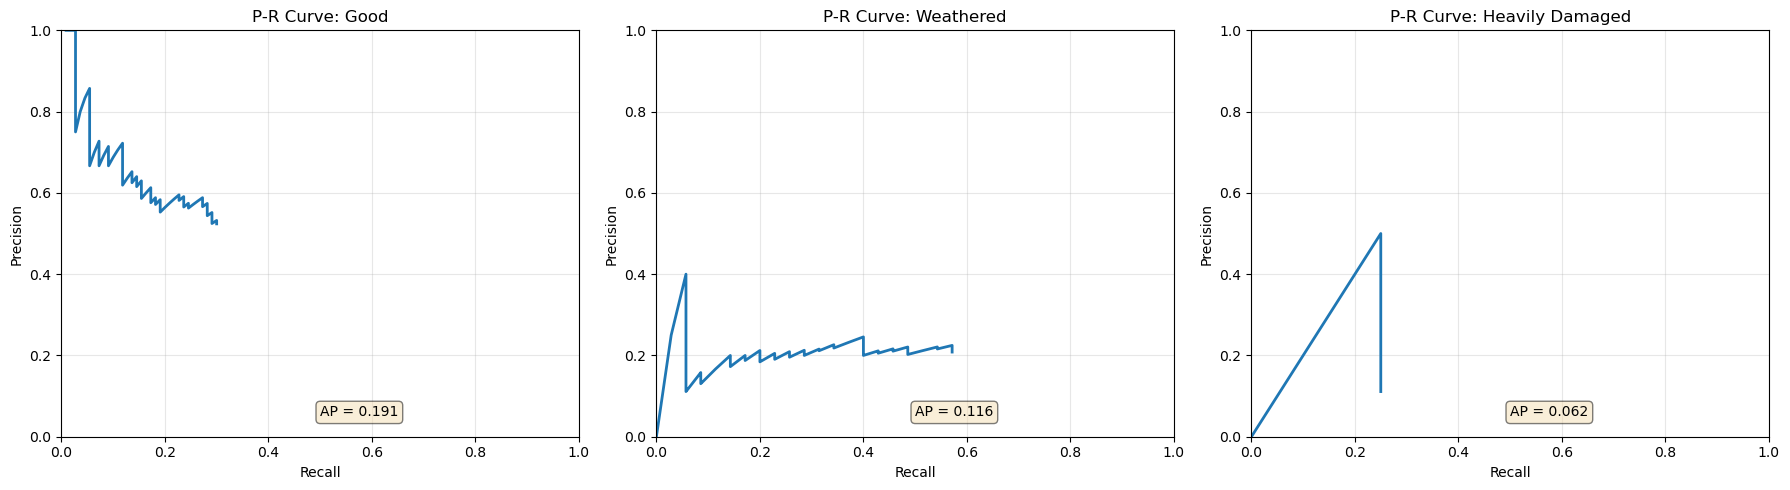



EVALUATION SUMMARY
Model: retinanet_best.pth
Test images: 122
Confidence threshold: 0.4

Overall Performance:
  Precision: 0.1607
  Recall: 0.1812
  F1-Score: 0.1703


In [ ]:
import torch
import torchvision
from torchvision.models.detection import retinanet_resnet50_fpn
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
import torchvision.transforms as T
import json
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import seaborn as sns

test_json = r'COCO-based_COCO_condition\annotations\test.json'
test_img_dir = r'COCO-based_COCO_condition\images\test'

allowed_conditions = ["Good", "Weathered", "Heavily Damaged"]
num_classes = 4

BATCH_SIZE = 4
NUM_WORKERS = 0

# model checkpoint to evaluate
MODEL_PATH = 'retinanet_best.pth'

#threshold
CONFIDENCE_THRESHOLD = 0.4

class FilteredCocoDetection(CocoDetection):
    def __init__(self, root, annFile, allowed_conditions):
        super().__init__(root, annFile)
        self.annFile = annFile
        self.allowed_conditions = allowed_conditions
        self._filter_annotations()
    
    def _filter_annotations(self):
        """Filter annotations to only include allowed conditions"""
        with open(self.annFile, 'r') as f:
            data = json.load(f)
        
        filtered_anns = []
        for ann in data['annotations']:
            if 'attributes' in ann and 'condition' in ann['attributes']:
                condition = ann['attributes']['condition'][0]
                if condition in self.allowed_conditions:
                    ann['category_id'] = self.allowed_conditions.index(condition) + 1
                    filtered_anns.append(ann)
        
        print(f"Filtered {len(data['annotations'])} -> {len(filtered_anns)} annotations")
        
        data['annotations'] = filtered_anns
        data['categories'] = [
            {'id': i+1, 'name': cond} for i, cond in enumerate(self.allowed_conditions)
        ]
        
        self.coco.dataset = data
        self.coco.createIndex()
    
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        img_id = self.ids[idx]
        
        # image to tensor
        img_tensor = T.ToTensor()(img)
        
        # target to proper format
        boxes = []
        labels = []
        
        for obj in target:
            if 'bbox' in obj and 'category_id' in obj:
                x, y, w, h = obj['bbox']
                boxes.append([x, y, x + w, y + h])
                labels.append(obj['category_id'])
        
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target_dict = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id])
        }
        
        return img_tensor, target_dict, img  # Return original PIL image too

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = retinanet_resnet50_fpn(weights=None)

#classification head
in_features = 256
num_anchors = model.head.classification_head.num_anchors

from torchvision.models.detection.retinanet import RetinaNetClassificationHead
model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_features,
    num_anchors=num_anchors,
    num_classes=num_classes
)

# Load checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print(f"Loaded model from {MODEL_PATH}")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")

test_dataset = FilteredCocoDetection(
    root=test_img_dir,
    annFile=test_json,
    allowed_conditions=allowed_conditions
)

print(f"Test set: {len(test_dataset)} images")

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    orig_images = [item[2] for item in batch]
    return images, targets, orig_images

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

def calculate_iou(box1, box2):
    """Calculate IoU between two boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0

all_predictions = []
all_targets = []

print("\nEvaluating model")
with torch.no_grad():
    for images, targets, orig_images in tqdm(test_loader, desc="Evaluating"):
        images = [img.to(device) for img in images]
        
        # getting predictions
        predictions = model(images)
        
        # process each image in batch
        for pred, target in zip(predictions, targets):
            # filter by confidence threshold
            keep = pred['scores'] > CONFIDENCE_THRESHOLD
            pred_boxes = pred['boxes'][keep]
            pred_labels = pred['labels'][keep]
            pred_scores = pred['scores'][keep]
            
            target_boxes = target['boxes']
            target_labels = target['labels']
            
            # store for confusion matrix and metrics
            all_predictions.append({
                'boxes': pred_boxes.cpu(),
                'labels': pred_labels.cpu(),
                'scores': pred_scores.cpu(),
                'image_id': target['image_id'].item()
            })
            
            all_targets.append({
                'boxes': target_boxes.cpu(),
                'labels': target_labels.cpu(),
                'image_id': target['image_id'].item()
            })


conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for pred, target in zip(all_predictions, all_targets):
    pred_labels = pred['labels'].numpy()
    target_labels = target['labels'].numpy()
    pred_boxes = pred['boxes'].numpy()
    target_boxes = target['boxes'].numpy()
    pred_scores = pred['scores'].numpy()
    
    matched_preds = set()
    
    # Match predictions to targets 
    for target_idx, target_label in enumerate(target_labels):
        target_box = target_boxes[target_idx]
        best_iou = 0
        best_pred_idx = None
        best_pred_label = None
        
        for pred_idx, pred_label in enumerate(pred_labels):
            pred_box = pred_boxes[pred_idx]
            iou = calculate_iou(pred_box, target_box)
            if iou > best_iou:
                best_iou = iou
                best_pred_idx = pred_idx
                best_pred_label = pred_label
        
        if best_iou >= 0.5 and best_pred_label is not None:
            # increment confusion matrix
            conf_matrix[target_label, best_pred_label] += 1
            matched_preds.add(best_pred_idx)
        else:
            # FN: target -> background (predicted as nothing)
            conf_matrix[target_label, 0] += 1
    
    # FP: predictions that didnt match any target
    for pred_idx, pred_label in enumerate(pred_labels):
        if pred_idx not in matched_preds:
            # Background -> predicted class (false positive)
            conf_matrix[0, pred_label] += 1

print("\n")
print("EVALUATION RESULTS")
# per-class metrics from confusion matrix
print(f"\nPer-Class Metrics:")
class_metrics = []

for class_id in range(1, num_classes):
    class_name = allowed_conditions[class_id - 1]
    
    # TP 
    tp = conf_matrix[class_id, class_id]
    
    # FP 
    fp = conf_matrix[0, class_id]  # Background predicted as this class
    for other_class in range(1, num_classes):
        if other_class != class_id:
            fp += conf_matrix[other_class, class_id]  # Other classes predicted as this class
    
    # FN
    fn = conf_matrix[class_id, 0]  
    for other_class in range(1, num_classes):
        if other_class != class_id:
            fn += conf_matrix[class_id, other_class]  
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # calculate average IoU for true positives
    avg_iou = 0
    iou_count = 0
    for pred, target in zip(all_predictions, all_targets):
        pred_labels = pred['labels'].numpy()
        target_labels = target['labels'].numpy()
        pred_boxes = pred['boxes'].numpy()
        target_boxes = target['boxes'].numpy()
        
        for target_idx, target_label in enumerate(target_labels):
            if target_label != class_id:
                continue
            target_box = target_boxes[target_idx]
            best_iou = 0
            best_pred_label = None
            
            for pred_idx, pred_label in enumerate(pred_labels):
                pred_box = pred_boxes[pred_idx]
                iou = calculate_iou(pred_box, target_box)
                if iou > best_iou:
                    best_iou = iou
                    best_pred_label = pred_label
            
            if best_iou >= 0.5 and best_pred_label == class_id:
                avg_iou += best_iou
                iou_count += 1
    
    avg_iou = avg_iou / iou_count if iou_count > 0 else 0
    
    print(f"{class_name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Avg IoU: {avg_iou:.4f}")
    print(f"  TP: {tp}, FP: {fp}, FN: {fn}")
    print()
    
    class_metrics.append({
        'class': class_name,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'avg_iou': avg_iou,
        'tp': tp,
        'fp': fp,
        'fn': fn
    })

# overall statistics
total_tp = sum(m['tp'] for m in class_metrics)
total_fp = sum(m['fp'] for m in class_metrics)
total_fn = sum(m['fn'] for m in class_metrics)

overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

print(f"\nOverall Metrics (IoU threshold = 0.5):")
print(f"  Precision: {overall_precision:.4f}")
print(f"  Recall: {overall_recall:.4f}")
print(f"  F1-Score: {overall_f1:.4f}")

# confusion matrix with background
plt.figure(figsize=(11, 9))
labels_with_bg = ['Background'] + allowed_conditions
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_with_bg,
            yticklabels=labels_with_bg,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('True', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix with Background (IoU > 0.5)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_with_background.png', dpi=150)
plt.show()



# Precision-Recall Curves
print("\nGenerating Precision-Recall Curves")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for class_id, class_name in enumerate(allowed_conditions, start=1):
    # collecting all predictions and ground truths for this class
    class_preds = []
    class_targets_count = 0
    
    for pred, target in zip(all_predictions, all_targets):
        # counting ground truth boxes
        class_targets_count += (target['labels'] == class_id).sum().item()
        
        # getting predictions for this class
        class_mask = pred['labels'] == class_id
        if class_mask.sum() > 0:
            scores = pred['scores'][class_mask].numpy()
            boxes = pred['boxes'][class_mask].numpy()
            
            # Check if predictions match ground truth
            for score, box in zip(scores, boxes):
                is_correct = False
                for target_box, target_label in zip(target['boxes'], target['labels']):
                    if target_label.item() == class_id:
                        iou = calculate_iou(box, target_box.numpy())
                        if iou >= 0.5:
                            is_correct = True
                            break
                class_preds.append({'score': score, 'correct': is_correct})
    
    # sorting by score
    class_preds.sort(key=lambda x: x['score'], reverse=True)
    
    # calculating precision and recall at different thresholds
    precisions = []
    recalls = []
    tp = 0
    fp = 0
    
    for pred in class_preds:
        if pred['correct']:
            tp += 1
        else:
            fp += 1
        
        precision = tp / (tp + fp)
        recall = tp / class_targets_count if class_targets_count > 0 else 0
        precisions.append(precision)
        recalls.append(recall)
    
    # Plot
    ax = axes[class_id - 1]
    ax.plot(recalls, precisions, linewidth=2)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'P-R Curve: {class_name}')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # calculate AP
    ap = np.trapezoid(precisions, recalls) if recalls else 0
    ax.text(0.5, 0.05, f'AP = {ap:.3f}',
            transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('precision_recall_curves.png', dpi=150)
plt.show()


def visualize_predictions(image, pred, target, idx):
    """Visualise predictions vs ground truth"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Convert tensor to numpy
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()
    else:
        image = np.array(image)
    
    # Ground truth
    ax1.imshow(image)
    ax1.set_title('Ground Truth', fontsize=14, fontweight='bold')
    for box, label in zip(target['boxes'], target['labels']):
        box = box.cpu().numpy()
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                linewidth=2, edgecolor='green', facecolor='none')
        ax1.add_patch(rect)
        ax1.text(x1, y1-5, allowed_conditions[label-1],
                color='white', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='green', alpha=0.7))
    ax1.axis('off')
    
    # predictions
    ax2.imshow(image)
    ax2.set_title('Predictions', fontsize=14, fontweight='bold')
    keep = pred['scores'] > CONFIDENCE_THRESHOLD
    for box, label, score in zip(pred['boxes'][keep], pred['labels'][keep], pred['scores'][keep]):
        box = box.cpu().numpy()
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                linewidth=2, edgecolor='red', facecolor='none')
        ax2.add_patch(rect)
        ax2.text(x1, y1-5, f"{allowed_conditions[label-1]} ({score:.2f})",
                color='white', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
    ax2.axis('off')
    
    plt.tight_layout()
    plt.savefig(f'prediction_sample_{idx}.png', dpi=150, bbox_inches='tight')
    plt.close()


print("\n")
print("EVALUATION SUMMARY")
print(f"Model: {MODEL_PATH}")
print(f"Test images: {len(test_dataset)}")
print(f"Confidence threshold: {CONFIDENCE_THRESHOLD}")
print(f"\nOverall Performance:")
print(f"  Precision: {overall_precision:.4f}")
print(f"  Recall: {overall_recall:.4f}")
print(f"  F1-Score: {overall_f1:.4f}")
